In [130]:
# Generic Comment
#* Important Comment
#! Warning
#? Suggestion
#TODO Todo list

import time
start_time = time.time()
import cyipopt
import math
import matplotlib.pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
from numba import *
%matplotlib widget

def compute_index(indices, dims):
    if len(indices) == 1:
        return indices[0]
    else:
        current_index = indices[0]
        remaining_dims_product = 1
        for dim in dims[1:]:
            remaining_dims_product *= dim
        return current_index * remaining_dims_product + compute_index(indices[1:], dims[1:])
        
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 0.000000 seconds 


# Encrypted Lyapunov Economic Model Predictive Control(LEMPC) of a Continuous Stirred Tank Reactor(CSTR)

In this code, we will apply Encrypted LEMPC to a CSTR to optimize the operation of the system based on our defined Economic model.

Note that in this design, the LEMPC is solved in the unencrypted space, but all signals are transmitted as encrypted signals, and decrpyted only when non-linear computation is needed.

## Encryption

Before encrypting a value, we first need to map it to the following quantized set:
\begin{align*}
\mathbb{Q}_{l_1,d}=\{x\in\mathbb{Q}\vert{}-2^{l_1-d-1}\leq{x}\leq{}2^{l_1-d-1}-2^{-d},\exists{k}\in\mathbb{Z}:x=k\times2^{-d}\}
\end{align*}

This is done via a function: 
\begin{align*}
g_{l_1,d}&:\mathbb{R}\rightarrow\mathbb{Q}_{l_1,d} \\
g_{l_1,d}(a)&:=\arg\min_{q\in{\mathbb{Q}_{l_1,d}}}\lvert{a-q}\rvert
\end{align*}

The Pallier Encryption Scheme only applies to $x\in\mathbb{Z}_n$ where $2^{n_{length}-1}\leq{n}<2^{n_{length}}-1$, with a function:
\begin{align*}
f_{l_2,d}&:\mathbb{Q}_{l_1,d}\rightarrow\mathbb{Z}_{2^{l_2}} \\
f_{l_2,d}(q)&:=2^dq{\bmod{}}2^{l_2}
\end{align*}

Because we define the key-length to be `n_length=128`, we say that $0\leq{x}\leq{2^{l_2}}<n$, i.e. $l_1\leq{l_2}<2^{n_{length}-1}$

Thus, we can simply say $l_2=l_1$, but we must ensure that $l_1<n_{length}$

Because of how the modulus operation works on negative numbers, and because we include 0 but exclude the upper bound while including the lower bound in our quantized set, all negative values will be at or above the median element of this set. Thus, we can invert the bijective mapping via:
\begin{align*}
f_{l_2,d}^{-1}&:\mathbb{Z}_{2^{l_2}}\rightarrow\mathbb{Q}_{l_1,d} \\
f_{l_2,d}^{-1}(m)&:=\frac{1}{2^d}\begin{cases} m-2^{l_2} & m\geq{2^{l_2-1}} \\ m & \text{otherwise}  \end{cases}
\end{align*}

In [131]:
start_time = time.time()
public_key, private_key = paillier.generate_paillier_keypair(n_length=256)
d1=12
def encrypt(val):
    return public_key.encrypt(val,precision = 2**(-d1))
def decrypt(val):
    return private_key.decrypt(val)


end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Encryption dependencies = %f seconds "
    % total_runtime
)

Total time required to initialize Encryption dependencies = 0.004504 seconds 


![EMPC_Diagram](EMPC_Diagram.png "lol")

In [132]:
start_time = time.time()
######### Simulation time #########################

hc = 1e-4  # hr Numerical Integration Step Size
tFinal = 1  # hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps = int( tFinal / hc)  # Number of calculated steps

controlStepSize   = 10 # Integration Steps per MPC Control Step

NUM_MPC_ITERATION = int(netTimeSteps/controlStepSize)  # Number of times simulation is run
HORIZON_LENGTH = 5

netControlTimeSteps   = int( netTimeSteps / controlStepSize   )

controlTimeStepsPerMPC   = int( HORIZON_LENGTH * netControlTimeSteps   / NUM_MPC_ITERATION )
timeStepsPerMPC          = int( HORIZON_LENGTH * netTimeSteps          / NUM_MPC_ITERATION )

controlTimeStepsPerControlAction   = int( netControlTimeSteps   / NUM_MPC_ITERATION )
timeStepsPerControlAction          = int( netTimeSteps          / NUM_MPC_ITERATION )

NUM_OUTPUTS = 2  # Model Outputs: x1 x2
NUM_INPUTS = 4  # Model  Inputs: u1 u2 x1 x2
NUM_U = int(NUM_INPUTS - NUM_OUTPUTS)  # Number of control inputs

NUM_MPC_INPUTS = int(NUM_U * controlTimeStepsPerMPC)  # 1 set of control inputs per Horizon
NUM_MPC_CONSTRAINTS = controlTimeStepsPerMPC  # Constraints must be satisfied at all points

delta = controlStepSize*hc
################### P matrix #############################
# V= xTP(x) "Energy of Sys"

a = 1060
b = 22
d = 0.52

#################### PI Controler Weights ###########
proportionalGainConcentration = 10
proportionalGainHeat = 10000
integralGain = 0.01

end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Control Paramters = %f seconds " % total_runtime
)

Total time required to initialize Control Paramters = 0.001506 seconds 


### ODE and parameters

The system model is described by the ordinary differential equation:
\begin{align*}
\dot{C}_A &= \frac{F}{V}(C_{A,0} - C_{A}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_A^2\\
\dot{T} &= \frac{F}{V}(T_0-T)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT}\right)}{\rho_L{C_P}}C_A^2+\frac{\dot{Q}}{\rho_LC_PV}\\
\end{align*}
For simplicity, we work with deviation variables and thus we subtract the steady state values for these ODEs
\begin{align*}
\dot{C}_{A_s} &= \frac{F}{V}(C_{{A,0}_s} - C_{A_s}) - k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{T_s} &= \frac{F}{V}(T_{0_s}-T_s)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{Q_s}}{\rho_LC_PV}\\
\end{align*}
Which results in our final expressions:
\begin{align*}
\dot{\bar{C}}_A &= \frac{F}{V}(\bar{C}_{A,0} - \bar{C}_{A}) - k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)(\bar{C}_A+C_{A_s})^2 + k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{\bar{T}} &= \frac{F}{V}(\bar{T}_0-\bar{T})-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)}{\rho_L{C_P}}(\bar{C}_A+C_{A_s})^2+\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{\bar{Q}}}{\rho_LC_PV}\\
\text{State-Variables}&=\begin{cases}
\bar{C}_A &= C_A - C_{A_s} \\
\bar{T} &= T - T_s \\
\end{cases}\\
\text{Control-Variables}&=\begin{cases}
\bar{C}_{A,0} &= C_{A,0} - C_{A_s,0} \\
\bar{Q} &= Q - Q_s \\
\end{cases}\\
\text{Redefined-Constants}&=\begin{cases}
\bar{T}_0 &= T_0 - T_{0,s} \\
\end{cases}\\
\text{Constants}&=\begin{cases}
F &= 5\frac{m^3}{hr} \\
V &= 1m^3 \\
\rho_L &= 1\times{10^3}\frac{kg}{m^3} \\
C_P &= 0.231\frac{kJ}{kg-K} \\
\Delta{H} &= -1.15\times{10^4}\frac{kJ}{kmol} \\
E &= 5\times{10^4}\frac{kJ}{kmol} \\
R &= 8.314\frac{kJ}{kmol-K} \\
k_0 &= 8.46\times{10^6}\frac{m^3}{kmol-hr} \\
T_0 &= 300K \\
T_{0_s} &= 300K \\
C_{A_s} &= 1.954 \frac{kmol}{m^3} \\
T_s &= 401.9K \\
Q_s &= 0 \frac{kJ}{hr} \\
C_{A_s,0} &= 4 \frac{kmol}{m^3} \\
\end{cases}
\end{align*}

All that remains is to define the initial values of the State-Variables in Deviation form, but this is up to the user to decide on values.

In [133]:
start_time = time.time()
##################### initial values and initializations ######################

# Initial Values in Deviation Variable Form
CA = 1.5  # kmol/m3
T = -60  # K

x_record = np.zeros((NUM_OUTPUTS, NUM_MPC_ITERATION + 1))
x_real = np.array([[CA], [T]])
x_record[:, [0]] = x_real


u_record = np.zeros((NUM_U, NUM_MPC_ITERATION))
offset_record = []
grad_f_record = []
cost_record = []

V_record = []
CostFun = []
status_record = []

realtime_data = None
cost = 0.0

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.954  # kmol/m3
Ts = 401.9  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

Total time required to initialize Model Paramters = 0.002004 seconds 


# MPC Constraints
The MPC design is as follows:

\begin{align*}
\min_{C_{A,0},Q}\sum_{k=1}^N&{-k_0C_A(t_k)^2\exp{\frac{-E_A}{RT(t_k)}}} \\
\dot{x}&=f(x)+g*u\\
u_L\leq&{u}\leq{u_U} \\
x(t_0) &= x_Q(t_0) \\
V\leq{90}\forall{t} &\text{ if }x((t_0))\in\Omega_{\rho_{min}}\\
\dot{V}_{MPC}(t_0)\leq\dot{V}_{PI}(t_0) &\text{ if }x((t_0))\in\Omega_{\rho}/\Omega_{\rho_{min}}\\
\end{align*}
where
\begin{align*}
x &= [C_A,T] \\
u &= [C_{A,0},Q] \\
P&=\bigg[
\begin{matrix}
a & b \\
b & d \\
\end{matrix}
\bigg]\\
V&=x^TPx \\
\dot{V}&=2x*P*f + 2x*P*g*u \\
\end{align*}

In [134]:
start_time = time.time()

@njit
def model_makestep(CA, T, CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - CA)
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - T)
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        CA += hc * fun_1
        T  += hc * fun_2
    return CA, T
   
def eval_f(u):  # L=xQx+uRu
    offset = 0
    x = x_real
    CA = x.item(0)
    T = x.item(1)
    ##Numerical Integration
    for controlIteration in range(controlTimeStepsPerMPC):
        CA0 = u.item(NUM_U * controlIteration + 0)
        Q   = u.item(NUM_U * controlIteration + 1)
        CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
        offset -=  k0 * math.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2# Sum the Cost at every future sampling time
    return offset*delta

# def eval_g(u):  # V condition, Vdot condition, the Energy constraint
#     g = np.array([1.0] * (controlTimeStepsPerMPC))  # Default to >0 i.e valid
#     x = x_real
#     CA = x.item(0)
#     T = x.item(1)
 
#     V_secure = 82.0
#     bias =  0.000065

#     V_predicted = ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))
#     if V_predicted<=V_secure:
#         for controlIteration in range(controlTimeStepsPerMPC):
#             CA0 = u.item(NUM_U * controlIteration + 0)
#             Q   = u.item(NUM_U * controlIteration + 1)
#             CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
#             g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # Ensure we stay in the economic region
#     else:
#         CA0 = u.item(0)
#         Q   = u.item(1)
#         # LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
#         #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
#         LfV = 0.0
#         Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
#         Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
#         dV_op2 = LfV + Lg1V * CA0 + Lg2V * Q  # (EMPC)Vdot = LfV(x)+LgV(x)*u

#         kc1 = 2.0
#         kc2 = 12000
#         u11 = kc1 * (0.0 - CA)
#         u22 = kc2 * (0.0 - T)
#         dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u

#         g[:] = min(0.0, dV_Pu2 - bias) - dV_op2 # Ensure we perform better than the Reference Controller
#     return g  # f(x) + C >= 0

def eval_g(u):  # V condition, Vdot condition, the Energy constraint
    g = np.array([1.0] * (controlTimeStepsPerMPC))  # Default to >0 i.e valid
    x = x_real
    CA = x.item(0)
    T = x.item(1)
 
    V_secure = 90
    bias =  0.000065
    mode = 2
    for controlIteration in range(controlTimeStepsPerMPC):
        CA0 = u.item(NUM_U * controlIteration + 0)
        Q   = u.item(NUM_U * controlIteration + 1)
        g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # Ensure we stay in the economic region
        if mode == 1:
            CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
            g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # Ensure we stay in the economic region
            continue
        else:
            if g[controlIteration] > 0:
                mode = 1
                CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)
                g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # Ensure we stay in the economic region
                continue
            else:
                # LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
                #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
                LfV = 0
                Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
                Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
                dV_op2 = LfV + Lg1V * CA0 + Lg2V * Q  # (EMPC)Vdot = LfV(x)+LgV(x)*u

                kc1 = 2
                kc2 = 12000
                u11 = kc1 * (0 - CA)
                u22 = kc2 * (0 - T)
                dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u

                g[controlIteration] = min(0, dV_Pu2 - bias) - dV_op2 # Ensure we perform better than the Reference Controller
                #break # Apply only first timestep
                CA,T = model_makestep(CA,T,CA0,Q,controlStepSize)            
    return g  # f(x) + C >= 0

cons = [
    {"type": "ineq", "fun": eval_g},
]
u_L = []
u_U = []
lowerBounds = [-3.5, -5e5]
upperBounds = [3.5, 5e5]
for _ in range(controlTimeStepsPerMPC):
    u_L = u_L + lowerBounds
    u_U = u_U + upperBounds
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize MPC Constraints = %f seconds " % total_runtime)

Total time required to initialize MPC Constraints = 0.001132 seconds 


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Running Main Code Loop




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Iteration # 1
Current State Variable Values: CA =  1.5 , T =  -60 K
Current V Value:  297.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Solving IPOPT...


Total time required to solve via IPOPT = 0.164706 seconds 
IPOPT Closed.
Objective Value: -0.011372411792016564
Constraints: [[ 914.9762007  1121.35889067 1447.90144544 2026.71754441 3180.00653102]]
Solve Status: 0
Number of Iterations: 18
Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).
Optimized u values are: [-0.33911133 30.64379883 -0.4206543  13.80859375 -0.55102539 12.37084961
 -0.78491211  7.7277832  -1.25927734  1.41552734]




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Iteration # 2
Current State Variable Values: CA =  1.498779296875 , T =  -60.0947265625 K
Current V Value:  296.0111380863191
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Solving IPOPT...
Total time required to solve via IPOPT = 0.027034 seconds 
IPOPT Closed.
Objective Value: -0.011343552315732114
Constraints: [[344.68956384 407.21727129 524.44153291 835.10162124 162.03201748]]
Solve Status: 0
Number of Iterations: 14
Algorithm terminated successfully at a l

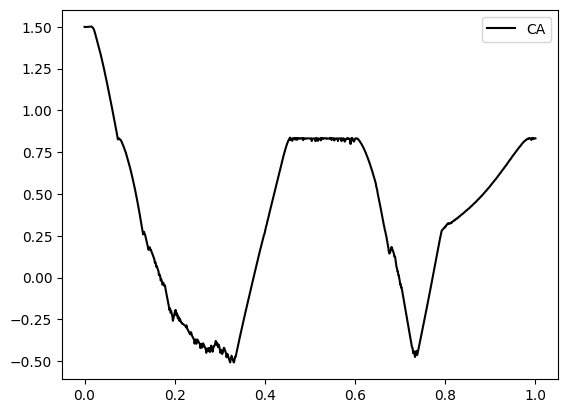

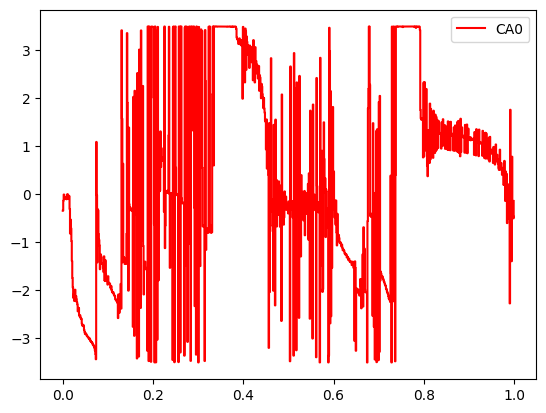

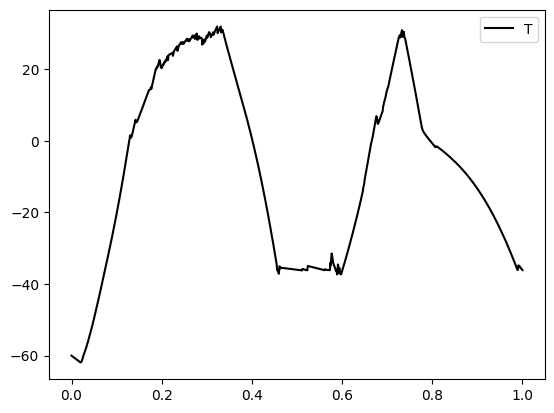

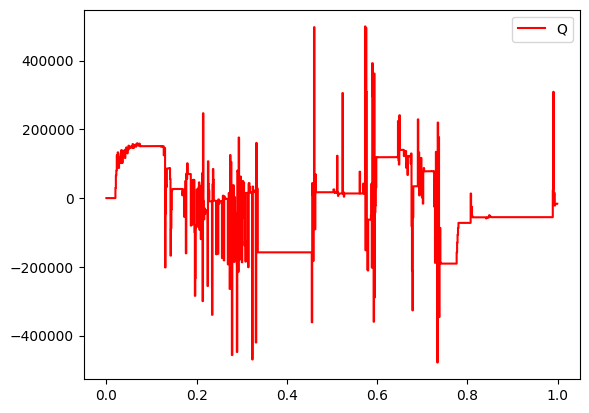

Total time required to execute the code = 43.686982 seconds 


In [135]:
#%%capture
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Running Main Code Loop")
# print("Number of times IPOPT will be called= ", NUM_MPC_ITERATION)
# print("Horizon Length = ", controlTimeSteps)
# print("Number of time steps per Horizon = ", integrationTimeSteps)
# print("Number of State Variables = ", NUM_OUTPUTS)
# print("Number of Control Inputs = ", NUM_U)
# print("Size of u matrix = ", NUM_MPC_INPUTS)
# print("Number of MPC Constraints = ", NUM_MPC_CONSTRAINTS)
for main_iteration in range(NUM_MPC_ITERATION):
    #####     Print Current Iteration Info     #####
    print("\n\n\n")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Iteration #", main_iteration + 1)
    print("Current State Variable Values: CA = ", CA, ", T = ", T, "K")
    print("Current V Value: ", (a * CA**2) + 2 * (b * CA * T) + (d * T**2))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    #####        Set-up control inputs         #####
    if main_iteration == 0:
        uUnoptimized = np.array([0.0] * NUM_MPC_INPUTS)  # which are u1 and u2 [Initialize blank array]
    else:
        #uUnoptimized = np.array([0.0] * NUM_MPC_INPUTS)
        uUnoptimized = u
        # Shift control inputs over 1 horizon(Last horizon is duplicated, but this is ok as we only sample and hold for 1 horizon)
        uUnoptimized[0:-NUM_U] = u[NUM_U:]
    for i in range(np.size(uUnoptimized)):
        uUnoptimized[i] = decrypt(encrypt(uUnoptimized[i]))
    #print("The value of u before optimization is ", uUnoptimized)
    # Set up and solve optimization problem via IPOPT
    print("Solving IPOPT...")
    start_time_IPOPT = time.time()
    soln = minimize_ipopt(
        eval_f,
        x0=uUnoptimized,
        bounds=bnds,
        constraints=cons,
        options={"maxiter": 10000, "tol": 1e-5},
    )
    end_time_IPOPT = time.time()
    total_runtime_IPOPT = end_time_IPOPT - start_time_IPOPT
    objectiveValue = soln.info['obj_val']
    constraintResults = (soln.info['g']).reshape(-1,1)
    solverStatus = soln.status
    print("Total time required to solve via IPOPT = %f seconds " % total_runtime_IPOPT)
    print("IPOPT Closed.")
    print("Objective Value:",objectiveValue)
    print("Constraints:", constraintResults.reshape(1,-1))
    print("Solve Status:",solverStatus)
    print("Number of Iterations:",soln.nit)
    print(soln.message.decode('utf-8'))

    # Print IPOPT Results
    u = soln.x
    for i in range(np.size(u)):
        u[i] = decrypt(encrypt(u[i]))
    print("Optimized u values are:", u)


    # Define the initial values of the Control Variables
    CA0 = u.item(0)
    Q   = u.item(1)
    u_record[:, [main_iteration]] = np.array([[CA0], [Q]])
    
    CA,T = model_makestep(CA,T,CA0,Q, controlStepSize)
    CA = decrypt(encrypt(CA))
    T = decrypt(encrypt(T))
    x_real = np.array([[CA],[T]])
    x_record[:, [main_iteration + 1]] = x_real
    ##Sum the Cost Function over every HORIZON
    cost_record.append((-k0 * np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2) * delta)
t = np.linspace(0, tFinal, int(tFinal / delta) + 1)

plt.plot(t, x_record[0, :], "k", label="CA")
plt.legend()
plt.show()

plt.step(t[:-1], u_record[0, :], "r", label="CA0", where="post")
plt.legend()
plt.show()

plt.plot(t, x_record[1, :], "k", label="T")
plt.legend()
plt.show()

plt.step(t[:-1], u_record[1, :], "r", label="Q", where="post")
plt.legend()
plt.show()

end_time = time.time()

total_runtime = end_time - start_time

print("Total time required to execute the code = %f seconds " % total_runtime)

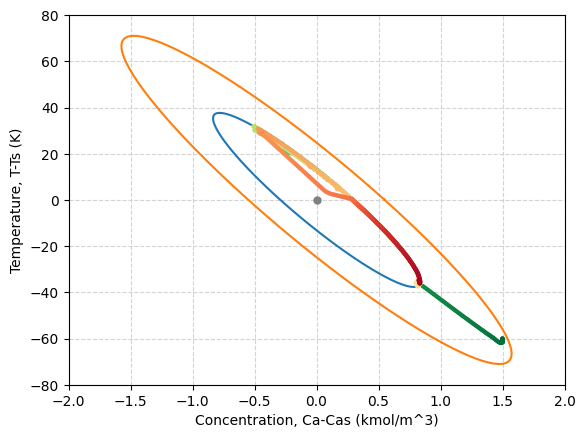

In [136]:
import os
import pickle
from math import cos, pi, sin

import numpy as np
from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -90
A2, B2, C2, F2 = 1060, 44, 0.52, -320
angle = 0.5 * np.arctan(B / (A - C))  # rotation angle
A_prime = A * (cos(angle)) ** 2 + B * cos(angle) * sin(angle) + C * (sin(angle)) ** 2
C_prime = A * (sin(angle)) ** 2 - B * cos(angle) * sin(angle) + C * (cos(angle)) ** 2
a = np.sqrt(-F / A_prime)  # radius on the x-axis
b = np.sqrt(-F / C_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

A_prime2 = (
    A2 * (cos(angle)) ** 2 + B2 * cos(angle) * sin(angle) + C2 * (sin(angle)) ** 2
)
C2_prime = (
    A2 * (sin(angle)) ** 2 - B2 * cos(angle) * sin(angle) + C2 * (cos(angle)) ** 2
)
a2 = np.sqrt(-F2 / A_prime2)  # radius on the x-axis
b2 = np.sqrt(-F2 / C2_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

u, v = 0, 0  # Unstable

t = np.linspace(0, 2 * pi, 100)
Ell = np.array(
    [a * np.cos(t), b * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot = np.zeros((2, Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])


Ell2 = np.array(
    [a2 * np.cos(t), b2 * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot2 = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot2 = np.zeros((2, Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:, i] = np.dot(R_rot2, Ell2[:, i])

plt.figure()

# Plot the ellipses (these remain static)
plt.plot(u + Ell_rot[0, :], v + Ell_rot[1, :])
plt.plot(u + Ell_rot2[0, :], v + Ell_rot2[1, :])
plt.xlim(-2, 2)
plt.ylim(-80, 80)
plt.xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
plt.yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
plt.xlabel("Concentration, Ca-Cas (kmol/m^3)")
plt.ylabel("Temperature, T-Ts (K)")

# startTime = 0
# endTime = 100
# Initialize an empty scatter plot for the animation
plt.plot(0,0,'-o',markersize=5,color='grey')
plt.scatter(x_record[0], x_record[1], c=np.linspace(0,1,len(x_record[0])),cmap='RdYlGn_r', vmin=0, vmax=1, s=5, zorder=3)
#plt.scatter(x_record[0][startTime:endTime], x_record[1][startTime:endTime], c=np.linspace(0,1,len(x_record[0][startTime:endTime])),cmap='RdYlGn_r', vmin=0, vmax=1, s=5, zorder=3)
plt.grid(color="lightgray", linestyle="--", zorder=1)
plt.savefig("ellipse.pdf")
plt.show()
#plt.savefig("ellipseCHEN.pdf")

In [137]:
sum(-k0 * np.exp(E_over_R / (x_record[1] + Ts)) * (x_record[0] + CAs) ** 2) * delta

np.float64(-10.974093667348155)

In [138]:
sum(u_record[0])

np.float64(382.708984375)

In [139]:
x_record[0][:50]

array([1.5       , 1.4987793 , 1.49853516, 1.49902344, 1.49926758,
       1.49951172, 1.49951172, 1.49975586, 1.5       , 1.5       ,
       1.50048828, 1.50073242, 1.5012207 , 1.5012207 , 1.50170898,
       1.50219727, 1.5012207 , 1.49780273, 1.49584961, 1.49291992,
       1.48876953, 1.48266602, 1.47485352, 1.46582031, 1.45581055,
       1.44628906, 1.43603516, 1.42626953, 1.41723633, 1.40698242,
       1.3972168 , 1.38720703, 1.37695312, 1.36645508, 1.35522461,
       1.34448242, 1.33374023, 1.32226562, 1.31054688, 1.29907227,
       1.28735352, 1.27539062, 1.26367188, 1.25146484, 1.23901367,
       1.2265625 , 1.21411133, 1.20166016, 1.1887207 , 1.17553711])

In [140]:
x_record[1][:50]

array([-60.        , -60.09472656, -60.18969727, -60.28466797,
       -60.37963867, -60.47485352, -60.57006836, -60.6652832 ,
       -60.76049805, -60.85595703, -60.95141602, -61.046875  ,
       -61.14233398, -61.23779297, -61.33349609, -61.42919922,
       -61.52490234, -61.62084961, -61.71704102, -61.81323242,
       -61.90966797, -61.87817383, -61.69213867, -61.44238281,
       -61.00170898, -60.66430664, -60.18701172, -59.73242188,
       -59.45214844, -59.03344727, -58.67919922, -58.30932617,
       -57.92822266, -57.58837891, -57.08520508, -56.65600586,
       -56.3137207 , -55.86230469, -55.36865234, -54.93286133,
       -54.47558594, -53.98168945, -53.57958984, -53.07104492,
       -52.60620117, -52.07177734, -51.58642578, -51.12646484,
       -50.6262207 , -50.12011719])

In [141]:
x_record[0][0:50]

array([1.5       , 1.4987793 , 1.49853516, 1.49902344, 1.49926758,
       1.49951172, 1.49951172, 1.49975586, 1.5       , 1.5       ,
       1.50048828, 1.50073242, 1.5012207 , 1.5012207 , 1.50170898,
       1.50219727, 1.5012207 , 1.49780273, 1.49584961, 1.49291992,
       1.48876953, 1.48266602, 1.47485352, 1.46582031, 1.45581055,
       1.44628906, 1.43603516, 1.42626953, 1.41723633, 1.40698242,
       1.3972168 , 1.38720703, 1.37695312, 1.36645508, 1.35522461,
       1.34448242, 1.33374023, 1.32226562, 1.31054688, 1.29907227,
       1.28735352, 1.27539062, 1.26367188, 1.25146484, 1.23901367,
       1.2265625 , 1.21411133, 1.20166016, 1.1887207 , 1.17553711])